### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("processed_train.csv")

In [5]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [6]:
### Your code is here

print(f"Всего объектов в выборке: {data['HasDetections'].shape[0]}")
print(f"Объектов 1: {data[data['HasDetections'] == 1].shape[0]}")
print(f"Объектов 0: {data[data['HasDetections'] == 0].shape[0]}")
print(f"Доля объектов с 1: {100*data[data['HasDetections'] == 1].shape[0] / data.shape[0]:.2f}%")

Всего объектов в выборке: 119952
Объектов 1: 20012
Объектов 0: 99940
Доля объектов с 1: 16.68%


Произведем процедуру отложенной выборки:

In [7]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [8]:
### Your code is here
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('LR', LogisticRegression(penalty='l2', C=0.01))
])

pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Accuracy на трейне: {(y_pred_train == y_train).sum() / y_train.shape[0]:.3f}")
print(f"Accuracy на тесте: {(y_pred_test == y_test).sum() / y_test.shape[0]:.3f}")

Accuracy на трейне: 0.841
Accuracy на тесте: 0.842


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [9]:
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)

### Your code is here

# TN, FP, FN, TP
TN = ((pred_test == 0) * (y_test.to_numpy() == 0)).sum()
FP = ((pred_test == 1) * (y_test.to_numpy() == 0)).sum()
FN = ((pred_test == 0) * (y_test.to_numpy() == 1)).sum()
TP = ((pred_test == 1) * (y_test.to_numpy() == 1)).sum()

TN, FP, FN, TP

(24727, 292, 4442, 527)

In [10]:
from sklearn.metrics import confusion_matrix

### Your code is here
cm = confusion_matrix(y_test, pred_test)
cm

array([[24727,   292],
       [ 4442,   527]], dtype=int64)

**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [11]:
### Your code is here

round(cm.diagonal().sum() / cm.sum(), 3)

0.842

Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [12]:
from sklearn.metrics import recall_score, precision_score

### Your code is here
round(recall_score(y_test, pred_test),3), round(precision_score(y_test, pred_test),3)

(0.106, 0.643)

In [13]:
dd = pd.Series([1. for i in range(990)] + [0. for i in range(10)]).to_numpy()
dd1 = np.ones(1000)

tp = ((dd == 1) * (dd1 == 1)).sum()
fp = ((dd == 0) * (dd1 == 1)).sum()
tn = ((dd == 0) * (dd1 == 0)).sum()
fn = ((dd == 1) * (dd1 == 0)).sum()

tp, fp, tn, fn, tp/(tp+fp), tp/(tp+fn)

(990, 10, 0, 0, 0.99, 1.0)

Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [26]:
### Your code is here
pred_probs = pipe.predict_proba(X_test)

**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [27]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6003734827264239
Recall: 	 0.12940229422418997
Threshold:	 0.45894877437904347


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [42]:
### Your code is here
precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

ix = np.where(precision == precision[recall > 0.2].max())

print(f"Precison:\t {precision[ix][-1]:.3f}")
print(f"Recall: \t {recall[ix][-1]:.3f}")
print(f"Threshold:\t {thres[ix][-1]:.3f}")

Precison:	 0.493
Recall: 	 0.200
Threshold:	 0.331


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [72]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 1000)
    y = np.linspace(0, 1.1, 1000)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 50, cmap='plasma');

Precision:	 0.170
Recall: 	 0.998
Threshold:	 0.022


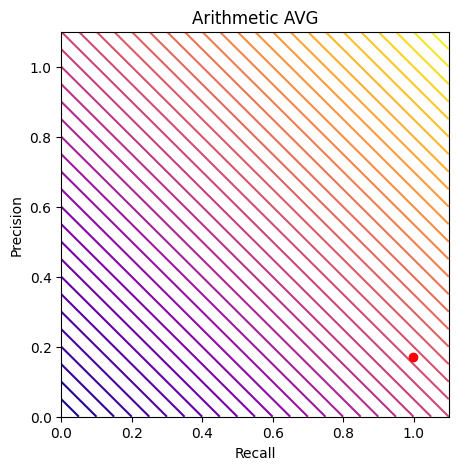

In [73]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]:.3f}")
print(f"Recall: \t {recall[arithm_idx]:.3f}")
print(f"Threshold:\t {thres[arithm_idx]:.3f}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro')

Precision:	 0.2239
Recall: 	 0.8094
Threshold:	 0.1260


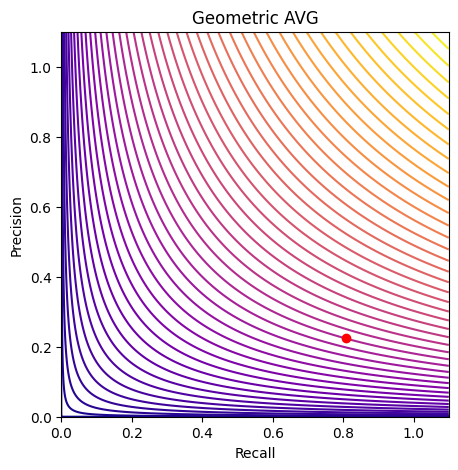

In [77]:
### Повторите для среднего геометрического
### Your code is here
metric_func = lambda x, y: (x*y)**0.5

geom_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[geom_idx]:.4f}")
print(f"Recall: \t {recall[geom_idx]:.4f}")
print(f"Threshold:\t {thres[geom_idx]:.4f}")

level_lines(metric_func, "Geometric AVG")
plt.plot(recall[geom_idx], precision[geom_idx], 'ro')

In [75]:
np.min([precision, recall], axis=0)

array([0.16569961, 0.16570514, 0.16571066, ..., 0.0004025 , 0.00020125,
       0.        ])

Precision:	 0.3586650583031765
Recall: 	 0.3590259609579392
Threshold:	 0.23662489521839355


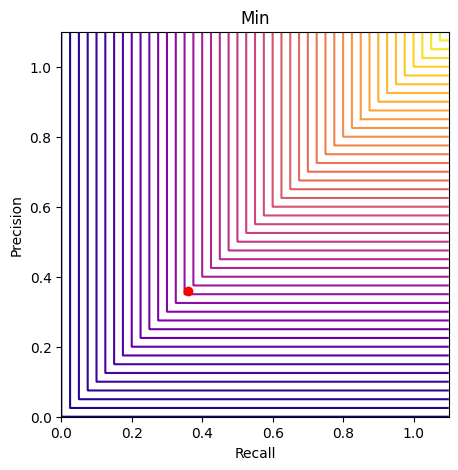

In [76]:
### Повторите для минимума
### Your code is here

metric_func = lambda x, y: np.min([x, y], axis=0)

min_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[min_idx]}")
print(f"Recall: \t {recall[min_idx]}")
print(f"Threshold:\t {thres[min_idx]}")

level_lines(metric_func, "Min")
plt.plot(recall[min_idx], precision[min_idx], 'ro')

**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

Precision:	 0.285
Recall: 	 0.524
Threshold:	 0.193


C:\Users\egort\AppData\Local\Temp\ipykernel_16944\358729007.py:6: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)


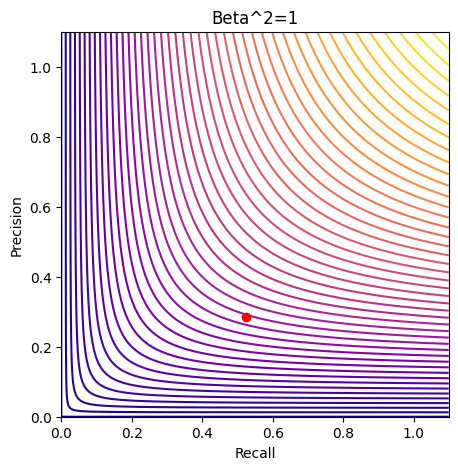

In [85]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here

beta2 = 1
metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)

argmax_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[argmax_idx]:.3f}")
print(f"Recall: \t {recall[argmax_idx]:.3f}")
print(f"Threshold:\t {thres[argmax_idx]:.3f}")

level_lines(metric_func, f"Beta^2={beta2}")
plt.plot(recall[argmax_idx], precision[argmax_idx], 'ro')

Precision:	 0.643
Recall: 	 0.109
Threshold:	 0.497
Max F1-score:	 0.521


C:\Users\egort\AppData\Local\Temp\ipykernel_16944\3934585330.py:6: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)


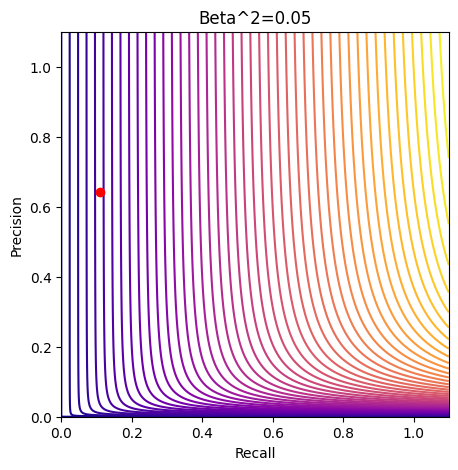

In [86]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here

beta2 = 0.05
metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)

argmax_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[argmax_idx]:.3f}")
print(f"Recall: \t {recall[argmax_idx]:.3f}")
print(f"Threshold:\t {thres[argmax_idx]:.3f}")
print(f"Max F1-score:\t {metric_func(precision, recall)[argmax_idx]:.3f}")

level_lines(metric_func, f"Beta^2={beta2}")
plt.plot(recall[argmax_idx], precision[argmax_idx], 'ro')

Precision:	 0.211
Recall: 	 0.860
Threshold:	 0.109
Max F1-score:	 0.532


C:\Users\egort\AppData\Local\Temp\ipykernel_16944\302879711.py:6: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)


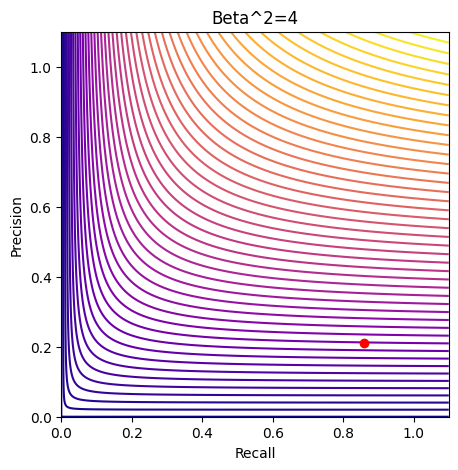

In [87]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here

beta2 = 4
metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)

argmax_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[argmax_idx]:.3f}")
print(f"Recall: \t {recall[argmax_idx]:.3f}")
print(f"Threshold:\t {thres[argmax_idx]:.3f}")
print(f"Max F1-score:\t {metric_func(precision, recall)[argmax_idx]:.3f}")

level_lines(metric_func, f"Beta^2={beta2}")
plt.plot(recall[argmax_idx], precision[argmax_idx], 'ro')

In [90]:
beta2 = 4 # recall's impact higher
metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)
metric_func(0.21, 0.863) # low precision, high recall

0.5320904286553142

In [91]:
beta2 = 4 # precisions's impact lower
metric_func = lambda p, r: (1 + beta2) * p * r / (beta2 * p + r)
metric_func(0.863, 0.21) # high precision, low recall

0.2474467504096122